In [ ]:
!pip install transformers==4.24.0
!pip install Pillow==10.0.0
!pip install -U sentence-transformers==2.2.2
!pip install datasets==2.14.4
!pip install sentencepiece==0.1.99

In [ ]:
import numpy as np
import typing as tp
import transformers
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast
from scipy.special import softmax
from google.colab import drive
from PIL import Image

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


# Intro to transformers assignment

Welcome! During this coding lesson you will be offered 5 coding tasks so that you could become familiar with Hugging Face ```transformers``` library. You will also see follow ups after some of the tasks to dive deeper into the topic. We encourage you to think about thise follow ups.

We are going to stop after each task and discuss in the audience progress, answer questions and share with each other thoughts about follow ups.

Read more about ```transformers``` https://huggingface.co/docs/transformers/index

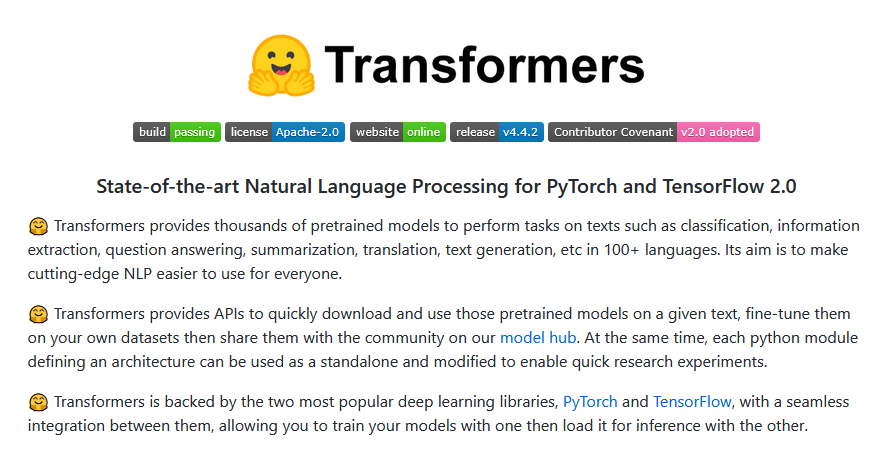

In [ ]:
Image.open(
    "/content/drive/MyDrive/oxford_llms_practice/day_1/images/transformers_overview.png"
)

### 1) Write a function to encode a sentence with pretrained tokenizer.

Write a function that takes as input sentence, any pretrained tokenizer from the Hugging Face Transformers library and optional parameter "max_length" to truncate tokenization wtih "max_length" number of tokens.


In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")


def tokenize(
    text: str,
    tokenizer: tp.Union[
        PreTrainedTokenizer, PreTrainedTokenizerFast
    ],  # read more about objects in https://huggingface.co/docs/transformers/main_classes/tokenizer
    max_length: tp.Optional[
        int
    ] = None,  # Choose max length wisely, think how this param relates to pretrained model you may want to use together with given tokenizer
):
    # return tokenizer.encode(text=text, max_length=max_length)
    return tokenizer(text=text, max_length=max_length)


sample_text = "Last year I visited London and I liked it a lot."

input_ids = tokenize(sample_text, tokenizer, max_length=100)
print(input_ids)
# test your function with a sentence above, choose tokenizer from any model you want

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


{'input_ids': [101, 2197, 2095, 1045, 4716, 2414, 1998, 1045, 4669, 2009, 1037, 2843, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Follow-ups:

* Analyse what objects are returned by tokenizer, what do they mean?
* Does the number of tokens equal to number of words? If not why? (Tokenizer documentation may help here)
* Try tokenizers from various transformer models. Do you see any difference with how tokenization works?
* Explore tokenizers documentation to learn more about it
* After reading docs write down up to 3 technical details about tokenizers that you found impressive, interesting or surpising :) We will later discuss it together

### 2) Write a function to decode token ids to actual tokens.
Function takes as input encoded text (e.g. from previous task) and a tokenizer object that was used to encode the text.

In [ ]:
def detokenize(
    encoded_text: str, tokenizer: tp.Union[PreTrainedTokenizer, PreTrainedTokenizerFast]
) -> tp.List[str]:
    return tokenizer.decode(token_ids=encoded_text, skip_special_tokens=True)


tokens = detokenize(input_ids["input_ids"], tokenizer)
print(tokens)

last year i visited london and i liked it a lot.


### 3) Find a model and write a code to translate the sentence from English to German with the given model.

Tokenise input, apply model, obtain prediction, decode and print output (actual trnslation of the input text)

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-de"

In [ ]:
model_name = "Helsinki-NLP/opus-mt-en-de"


def translate_text(text: str, model_name: str) -> str:
    model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

    input_ids = tokenizer(input, return_tensors="pt")
    outputs = model.generate(**input_ids)
    decoded = detokenize(outputs[0], tokenizer)
    print(decoded)


input = "London is the capital of Great Britain"

translate_text(input, model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


London ist die Hauptstadt Großbritanniens


Follow ups:
* There are present models that were trained specifically to translate from one language to another (e.g. from English to German). Are there more general models capable to translate to/from various languages? How to use them?

### 4) Understanding model outputs.

You are given a model that is able to predict 7 types of emotions from the text. Read more about the model https://huggingface.co/j-hartmann/emotion-english-distilroberta-base

Let's say you encoded the input and obrained model output that is stored in the ```outputs``` variable. Answer the following questions:
* What does ```outputs``` store?
* How to get predicted emption from  ```outputs``` ?
* Can we get from the``` outputs``` the least probable emotion among all 7 possible emotions types?

In [ ]:
model_name = "j-hartmann/emotion-english-distilroberta-base"

model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
config = transformers.AutoConfig.from_pretrained(model_name)

In [ ]:
config

In [ ]:
def get_most_and_least_probable_labels(
    text: str,
    tokenizer: tp.Union[PreTrainedTokenizer, PreTrainedTokenizerFast],
    model: transformers.PreTrainedModel,
    config: dict,
) -> dict:
    encoded = tokenizer(text, return_tensors="pt")
    outputs = model(**encoded)

    scores = outputs.logits[0].detach().numpy()
    scores = softmax(scores)

    predicted_id = np.argmax(scores)
    predicted_emotion = config.id2label[predicted_id]

    id_with_least_proba = np.argmin(scores)
    least_predicted_emotion = config.id2label[id_with_least_proba]
    return {
        "most_probable_emotion": predicted_emotion,
        "least probable emotion": least_predicted_emotion,
    }


input = "This was the worst experience ever!!!"

outputs = get_most_and_least_probable_labels(input, tokenizer, model, config)

print(outputs)

{'most_probable_emotion': 'disgust', 'least probable emotion': 'joy'}


### 5) Is anything wrong with the logic below?
Discuss if such model and tokenizer initialisation may cause any problems.


In [ ]:
model_name = "bert-base-uncased"
tokenizer_name = "bert-base-cased"

model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

# model and tokenizer should be the same. If a model was trained with uncased tokenizer, but during inference you will use cased tokenizer, there  will be poor results. Consider using same tokenizer that was used during model training.

Follow ups:
read more about model outputs possible formats in Hugging Face docs https://huggingface.co/docs/transformers/main_classes/output